## Model explainability

The growing availability of big data has increased the benefits of using complex models, forcing data scientists to choose between accuracy and interpretability of a model’s output. Adding explainability methods to models that are not easily understood helps:

- Ensure transparency algorithmic decision-making
- Identify potential bias in the training data
- Give a deeper understanding of the process being modeled

These methods are able to give insight into why your model generates specific outputs; explainability algorithms are especially useful in highly regulated industries (ie, pinpoint the attributes that caused someone to be denied/approved a home loan). We'll demonstrate an [anchor explainer](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf) in this notebook to better understand why a generic image detection model is creating certain outputs using the library [seldon-core](https://github.com/SeldonIO/seldon-core).

In [1]:
#!pip install tensorflow matplotlib alibi seldon_core

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from alibi.explainers import AnchorImage
from seldon_core.seldon_client import SeldonClient

To begin, we will set up a SeldonClient, which is how we will communicate to the classifier model that was deployed to our cluster via the Seldon operator. This model, named `image-default-classifier` is deployed into the `image-classifier` namespace and uses gRPC transport via port 9001.

In [3]:
# gateway endpoint is model-name.namespace-name:port

sc = SeldonClient(gateway_endpoint="image-default-classifier.image-classifier:9001",\
                  grpc_max_send_message_length= 27 * 1024 * 1024,\
                  grpc_max_receive_message_length= 27 * 1024 * 1024)

Next, we load and format the photo into a machine readable array.

PIL image size (299, 299)


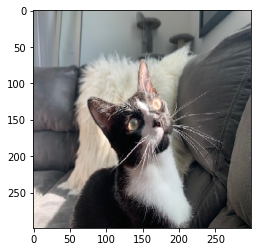

In [4]:
#Load photo
filename = '../data/cat.jpg'
original = load_img(filename, target_size=(299, 299))

#Format custom picture
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)

#Display
print('PIL image size',original.size)
plt.imshow(original)
plt.show()

Success! This is a photo I took of my own cat, so I can confidently know that the model has never seen the picture before. To a human eye, it is (hopefully) pretty obvious that the image is of a cat. We'll use it to see how to model reacts to images that are not in the training data. This is important to test, since oftentimes training data, especially images, does not accurately reflect photos that are taken by you or I. For example, the training photos may all have centered images in good lighting with nothing in the background, which is unrealistic for everyday images.

Now that we have our image ready, we can use the model to make a prediction for our cat! We'll use the client we made earlier and a predict function.

In [5]:
cat_predict = sc.predict(transport="grpc",\
                         data=image_batch,\
                         payload_type="tftensor",\
                         gateway="ambassador",\
                         client_return_type="dict")

The predict function returns the predictions via [Softmax](https://en.wikipedia.org/wiki/Softmax_function), which mean that the prediction can be translated as the probability that the image falls into one of the categories given in training. Because of this, we have to reformat the response and map the probabilities to each category.

In [6]:
#Reformat results
cat_values = np.asarray(cat_predict.response['data']['tftensor']['floatVal'])
shape = np.asarray([1,1000])
cat_preds = cat_values.reshape(shape)

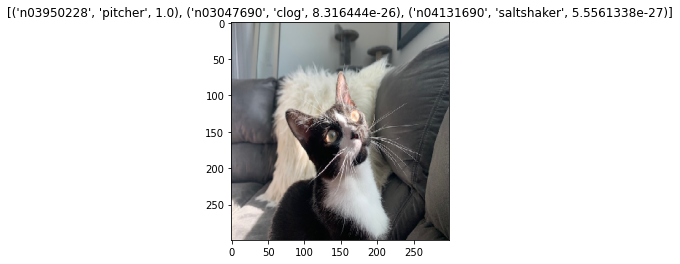

In [7]:
#Display results
label = decode_predictions(cat_preds, top=3)
plt.title(label[0])
plt.imshow(original)

Even though we see this as a cat, the model gives a 100% probability that the image shows a pitcher. There are a few things to note here. The first is, because this is a Softmax output, the model only gives us the names of its best guesses, not how strong the prediction is. This is a subtle differentiation. The model believes that pitcher is definitely the _best_ guess, but it could only be 1% certain in this prediction. To solve this, we could add new outcome metrics, or tweak the model. Before we do any of that though, it could be useful for us to better understand how the model is making this prediction.

This is a good moment for us to utilize explainers. We will use a local version of the model to build an [anchor](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf) explainer. This will show us what parts of the photo the model used in order to give the "pitcher" prediction.

In [8]:
# use local model, from tensorflow 
model = InceptionV3(weights='imagenet')
image_shape = (299, 299, 3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
# explainer, from alibi library
explainer = AnchorImage(model, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


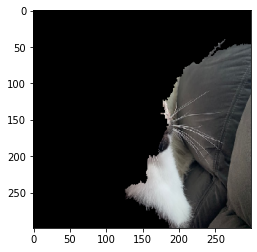

In [9]:
cat_image = image_batch[0]
explanation = explainer.explain(cat_image, threshold=.95, \
                                p_sample=.5, tau=0.25)

plt.imshow(explanation.anchor)

It looks as though the model uses primarily the background to create this prediction, so it comes as no surprise that the classification is wildly incorrect. With this information in mind, data scientists may decide to go back and create a more robust exploration of the data and model. It may be the case that the training data of cats has only solid backgrounds, different lighting, different color/hair length cat, or some other feature that caused this image to not be identified correctly. 

Explainers will not fix the model itself. However, they are useful tools for data scientists to build well-architected models by exposing bias in training data and giving transparency to black-box models.